# Simple example on using Instrumental Variables method for estimation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import patsy as ps

from statsmodels.sandbox.regression.gmm import IV2SLS
import os, sys
from dowhy import CausalModel

## Loading the dataset

We create a fictitious dataset with the goal of estimating the impact of education on future earnings of an individual. The `ability`  of the individual is a confounder and being given an `education_voucher` is the instrument.

In [3]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points) 

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

# build dataset (exclude confounder `ability` which we assume to be unobserved)
data = np.stack([education, income, voucher]).T
df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

## Using DoWhy to estimate the causal effect of education on future income

We follow the four steps: 
1) model the problem using causal graph, 

2) identify if the causal effect can be estimated from the observed variables, 

3) estimate the effect, and 

4) check the robustness of the estimate. 

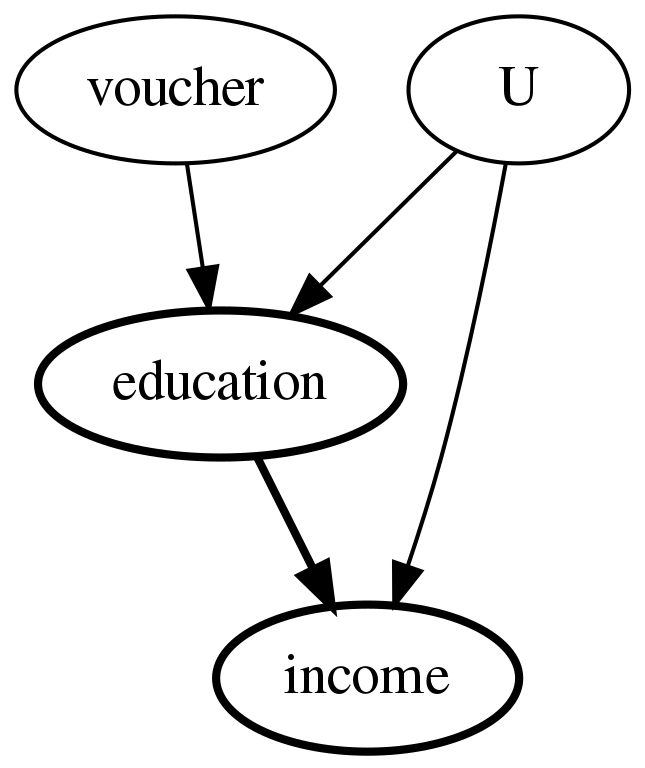

In [4]:
#Step 1: Model
model=CausalModel(
        data = df,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
# Step 3: Estimate
#Choose the second estimand: using IV
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

instrumental_variable


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                                    -1
Expectation(Derivative(income, voucher))⋅Expectation(Derivative(education, voucher))  
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['education'] is affected in the same way by common causes of ['education'] 

We have an estimate, indicating that increasing `education` by one unit increases `income` by 4 points.  

Next we check the robustness of the estimate using a Placebo refutation test. In this test, the treatment is replaced by an independent random variable (while preserving the correlation with the instrument), so that the true causal effect should be zero. We check if our estimator also provides the correct answer of zero. 

In [7]:
# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute") # only permute placebo_type works with IV estimate
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:3.9371469592713266
New effect:-0.0325327217605466
p value:0.41000000000000003



The refutation gives confidence that the estimate is not capturing any noise in the data.

Since this is simulated data, we also know the true causal effect is `4` (see the `income_education` parameter of the data-generating process above)

Finally, we show the same estimation by another method to verify the result from DoWhy.

In [8]:
income_vec, endog = ps.dmatrices("income ~ education", data=df)
exog = ps.dmatrix("voucher", data=df)

m = IV2SLS(income_vec, endog, exog).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                 income   R-squared:                       0.885
Model:                         IV2SLS   Adj. R-squared:                  0.885
Method:                     Two Stage   F-statistic:                     1183.
                        Least Squares   Prob (F-statistic):          1.33e-171
Date:                Sun, 20 Mar 2022                                         
Time:                        20:11:08                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3959      1.056      9.841      0.000       8.323      12.469
education      3.9371      0.114     34.393      0.000       3.713       4.162
==============================================================================
Omnibus:                        1.910   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.915
Skew:                          -0.068   Prob(JB):                        0.384
Kurtosis:                       2.834   Cond. No.                         26.1
==============================================================================
"""